In [1]:
%matplotlib widget

In [2]:
import time
start_time = time.perf_counter()
import sys
print(sys.executable)
print(sys.version)
import os
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "0"

/users/kieffer/.venv/py39/bin/python
3.9.5 (default, Jun  4 2021, 12:28:51) 
[GCC 7.5.0]


In [3]:
pix = 100e-6
shape = (1024, 1024)
npt = 1000
nimg = 1000
wl = 1e-10
I0 = 1e2
kwargs = {"npt":npt,
         "correctSolidAngle":False,
         "polarization_factor":None,
         "safe":False,
         "error_model":"Poisson",
         "method":("no", "csr", "python"),
         }
         # "normalization_factor": 1.0}


In [4]:
import numpy
from scipy.stats import chi2 as chi2_dist
from matplotlib.pyplot import subplots
from matplotlib.colors import LogNorm
import logging
logging.basicConfig(level=logging.ERROR)
import pyFAI
print(f"pyFAI version: {pyFAI.version}")
from pyFAI.detectors import Detector
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from pyFAI.method_registry import IntegrationMethod
from pyFAI.gui import jupyter
detector = Detector(pix, pix)
detector.shape = detector.max_shape = shape
print(detector)

pyFAI version: 0.22.0-dev6
Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m


In [5]:
ai_init = {"dist":1.0,
           "poni1":0.0,
           "poni2":0.0,
           "rot1":0.0,
           "rot2":0.0,
           "rot3":0.0,
           "detector":detector,
           "wavelength":wl}
ai = AzimuthalIntegrator(**ai_init)
print(ai)

Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m
Wavelength= 1.000000e-10m
SampleDetDist= 1.000000e+00m	PONI= 0.000000e+00, 0.000000e+00m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 1000.000mm	Center: x=0.000, y=0.000 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


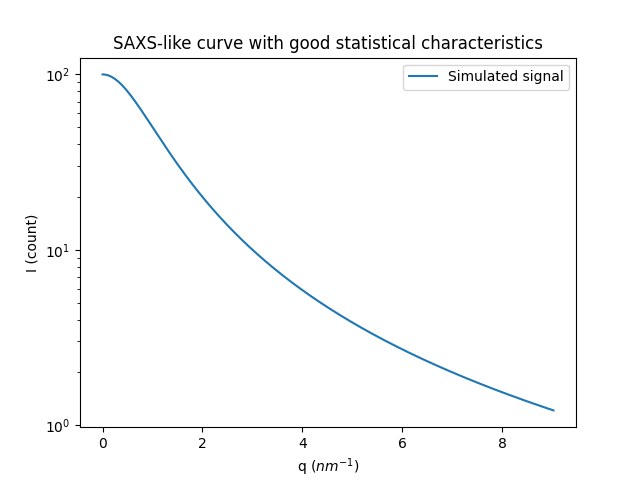

In [6]:
# Generation of a "SAXS-like" curve with the shape of a lorentzian curve
unit="q_nm^-1"
q = numpy.linspace(0, ai.array_from_unit(unit=unit).max(), npt)
I = I0/(1+q**2)
fig, ax = subplots()
ax.semilogy(q, I, label="Simulated signal")
ax.set_xlabel("q ($nm^{-1}$)")
ax.set_ylabel("I (count)")
ax.set_title("SAXS-like curve with good statistical characteristics")
ax.legend()
pass

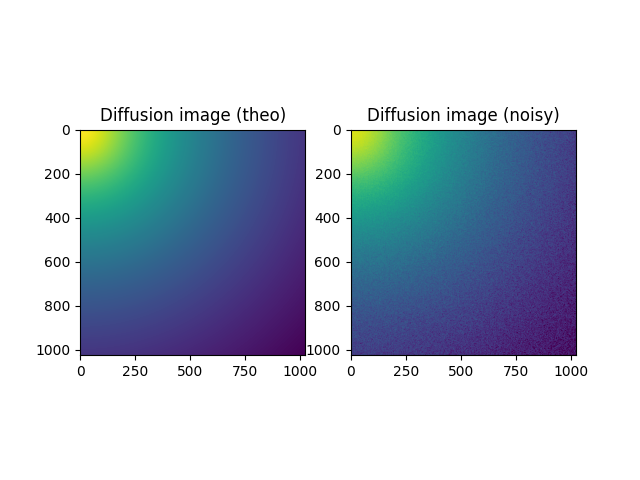

In [7]:
#Reconstruction of diffusion image:

img_theo = ai.calcfrom1d(q, I, dim1_unit="q_nm^-1",
                         correctSolidAngle=False,
                         polarization_factor=None)
img_poisson = numpy.random.poisson(img_theo)
fig, ax = subplots(1, 2)
ax[0].imshow(img_theo, norm=LogNorm())
_=ax[0].set_title("Diffusion image (theo)")
ax[1].imshow(img_poisson, norm=LogNorm())
_=ax[1].set_title("Diffusion image (noisy)")

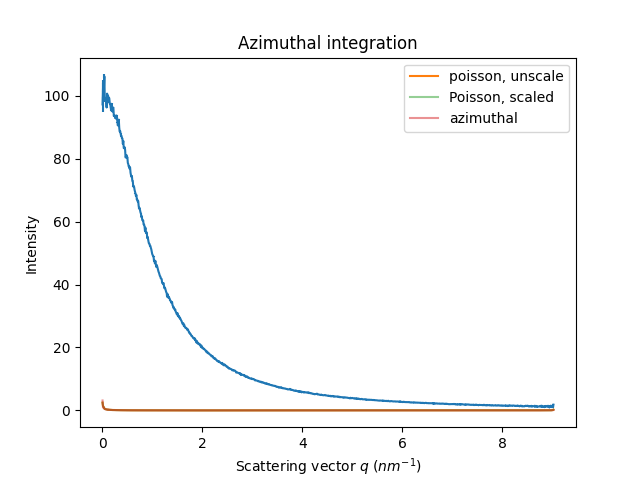

In [8]:
factor = 1e-6
k = kwargs.copy()
k["error_model"] = "azimuthal"
res_azim = ai.integrate1d(img_poisson, **k)
res_renorm = ai.integrate1d(img_poisson, normalization_factor=factor, **kwargs)
ref = ai.integrate1d(img_poisson, **kwargs)
ax = jupyter.plot1d(ref)
ax.plot(ref.radial, ref.sigma, label="poisson, unscale")
ax.plot(res_renorm.radial, res_renorm.sigma*factor, alpha=0.5, label="Poisson, scaled")
ax.plot(res_azim.radial, res_azim.sigma, alpha=0.5, label="azimuthal")

ax.legend()
_=ax.set_title("Azimuthal integration")

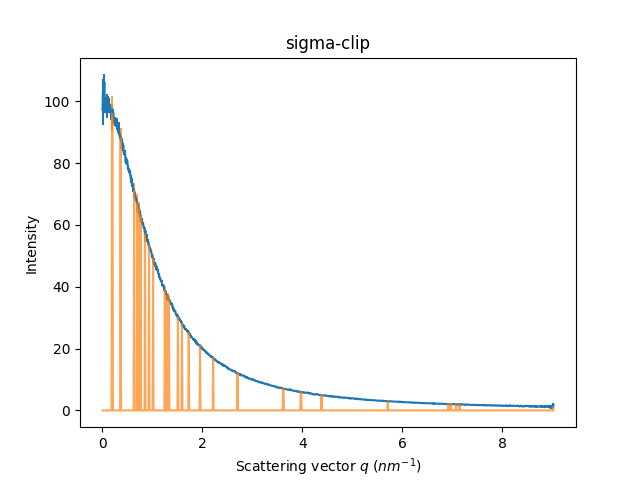

In [9]:
factor = 1e-6
res_renorm = ai.sigma_clip_ng(img_poisson, normalization_factor=factor, max_iter=1, **kwargs)
ax = jupyter.plot1d(ai.sigma_clip_ng(img_poisson, max_iter=1, **kwargs))
ax.errorbar(res_renorm.radial, res_renorm.intensity*factor, res_renorm.sigma*factor, alpha=0.7)
_=ax.set_title("sigma-clip")